In [4]:
#Most of the code is copied from https://github.com/mangye16/Unsupervised_Embedding_Learning
from __future__ import print_function

import sys
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import time
import numpy as np

import torchvision.datasets as datasets
import math
from easydict import EasyDict as edict
from torch.utils.tensorboard import SummaryWriter

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler


from PIL import Image
import matplotlib.pyplot as plt
import umap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

from scipy.sparse.linalg import cg
from scipy.sparse import csr_matrix, identity, diags
from scipy.stats import entropy

import faiss
from progressbar import ProgressBar
from scipy.stats import bernoulli

import warnings
warnings.simplefilter('ignore')

# Hard location of path 
# Labels = "../labels/cifar10/250_balanced_labels/00.txt" 
suffix = 'cifar_mixmatch' # Change this suffix to a suitable name for the experiment for tensorboard and logging

In [5]:
def generate_subset_of_CIFAR_for_ssl(samples_per_class, label_sample_per_class=25, seed=1):
    '''Generate label and unalabel index for CIFAR10, total unlabel index is same as no of samples
    
    Args:
        
        samples_per_class(int): no. of images to be considered per class, maximum posisble is 5000
        
        label_sample_per_class(int): no. of label images per class, must be less than equal to samples_per_class, 
        default is 25
        
    
    Returns:
        index for unlabel and label
    '''
 
    trainset_cifar = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
    trainloader = torch.utils.data.DataLoader(trainset_cifar, batch_size=1024, shuffle=False, num_workers=20)
    
    list_of_target = []
    for i, (_, target) in enumerate(trainloader):
        list_of_target.append(target)
    list_of_target = torch.cat(list_of_target).numpy()
    
    np.random.seed(seed)
    sampled_index = []
    index_for_label = []
    for i in range(10):
        ii = np.where(list_of_target == i)[0]
        cls_sample = list(np.random.choice(ii, samples_per_class, replace=False))
        sampled_index.extend(cls_sample)
        cls_sample_labeled = list(np.random.choice(cls_sample, label_sample_per_class, replace=False))
        index_for_label.extend(cls_sample_labeled)
    
    sampled_index = list(set(sampled_index)-set(index_for_label))
    return sampled_index, index_for_label

unlabel_index, label_index = generate_subset_of_CIFAR_for_ssl(5000, 25, 1)

Files already downloaded and verified


In [27]:
# batch-t: softmax temperature parameter (0.05-0.1)
# low-dim: the feature embedding dimension (default: 128)

args = edict({'dataset':'cifar', 'lr': .05, 'resume': '', 'log_dir': 'log/', 'model_dir': 'checkpoint/',
              'test_epoch': 1, 'low_dim': 128, 'batch_t': .1, 'batch_m': 1, 'batch_size': 500, 'gpu': '0, 1, 2',
              'alpha': .8 }) 
os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'

vis_log_dir = args.log_dir + suffix + '/'
if not os.path.isdir(vis_log_dir):
    os.makedirs(vis_log_dir)
writer = SummaryWriter(log_dir=vis_log_dir)

In [28]:
# Resnet Model

class Normalize(nn.Module):

    def __init__(self, power=2, temp=1):
        super(Normalize, self).__init__()
        self.power = power
        self.temp = temp
    
    def forward(self, x):
        norm = x.pow(self.power).sum(1, keepdim=True).pow(1./self.power)
        out = x.div(norm)
        return out/self.temp
    
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, pool_len =4, low_dim=128, fixed_classifier=False, temp=1):
        super(ResNet, self).__init__()
        self.temp = temp
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear_embedding = nn.Linear(512*block.expansion, low_dim)
        self.linear_class = nn.Linear(low_dim, 10, bias=False)
        if fixed_classifier:
            M = np.random.normal(0, 1, size=(low_dim, low_dim))
            ortho, _, _ = np.linalg.svd(M)
            ortho = ortho[:10]
            self.linear_class.weight.data = torch.tensor(ortho, dtype=torch.float).cuda()
            self.linear_class.weight.detach_()
        # with torch.no_grad():
        #     self.linear_class.weight.div_(torch.norm(self.linear_class.weight, dim=1, keepdim=True))
        self.l2norm_for_feature = Normalize()
        # self.l2norm_for_weight = Normalize(temp=.1)
        self.pool_len = pool_len
        # w = torch.nn.Parameter(torch.randn(128, 10))
        # for m in self.modules():
            # if isinstance(m, nn.Conv2d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
            # elif isinstance(m, nn.BatchNorm2d):
                # m.weight.data.fill_(1)
                # m.bias.data.zero_()
                

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, self.pool_len)
        out = out.view(out.size(0), -1)
        out_embedding = self.linear_embedding(out)
        out_embedding = self.l2norm_for_feature(out_embedding)
        # with torch.no_grad():
        #     self.linear_class.weight.div_(torch.norm(self.linear_class.weight, dim=1, keepdim=True))
        # self.linear_class.weight.div_(torch.norm(self.linear_class.weight, dim=1, keepdim=True))
        # type(self.l2norm_for_weight(self.linear_class.weight))
        # self.linear_class.weight = self.l2norm_for_weight(self.linear_class.weight)
        # self.linear_class.weight = torch.nn.Parameter(10 * self.linear_class.weight/torch.norm(self.linear_class.weight, dim=1, keepdim=True))
        # out_class = 10*self.linear_class(out_embedding)/torch.norm(self.linear_class.weight, dim=1, keepdim=True).transpose(1,0)
        out_class = self.linear_class(out_embedding)
        return out_embedding, out_class/self.temp
        # return out_embedding, out_class

    # def normalize_weight(self):
    #     with torch.no_grad():
    #         self.linear_class.weight.div_(torch.norm(self.linear_class.weight, dim=1, keepdim=True))



def ResNet18(pool_len = 4, low_dim=128, fixed_weight=True, temperature=1):
    return ResNet(BasicBlock, [2,2,2,2], pool_len, low_dim, fixed_classifier= fixed_weight, temp=temperature)


class BatchCriterion(nn.Module):  # Unsupervised Loss
    ''' Compute the unsupervised loss within each batch  
    '''
    def __init__(self, T, batchSize):
        super(BatchCriterion, self).__init__()
        self.T = T
        self.diag_mat = 1 - torch.eye(batchSize*2).cuda()
        
    def forward(self, x, targets):
        batchSize = x.size(0)
        
        #get positive innerproduct
        reordered_x = torch.cat((x.narrow(0,batchSize//2,batchSize//2), x.narrow(0,0,batchSize//2)), 0)
        #reordered_x = reordered_x.data
        pos = (x*reordered_x.data).sum(1).div_(self.T).exp_()

        #get all innerproduct, remove diag
        all_prob = torch.mm(x,x.t().data).div_(self.T).exp_()*self.diag_mat
        all_div = all_prob.sum(1)
        

        lnPmt = torch.div(pos, all_div)

        # negative probability
        Pon_div = all_div.repeat(batchSize,1)
        lnPon = torch.div(all_prob, Pon_div.t())
        lnPon = -lnPon.add(-1)
        
        # equation 7 in ref. A (NCE paper)
        lnPon.log_()
        # also remove the pos term
        lnPon = lnPon.sum(1) - (-lnPmt.add(-1)).log_()
        lnPmt.log_()

        lnPmtsum = lnPmt.sum(0)
        lnPonsum = lnPon.sum(0)

        loss = - (lnPmtsum + lnPonsum)/batchSize
        return loss

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed at 120, 160 and 200"""
    lr = args.lr
    if epoch >= 120 and epoch < 160:
        lr = args.lr * 0.1
    elif epoch >= 160 and epoch < 200:
        lr = args.lr * 0.05
    elif epoch >= 200:
        lr = args.lr * 0.01
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    writer.add_scalar('lr', lr, epoch)
    



In [29]:
class CIFAR10Instance(datasets.CIFAR10):
    """CIFAR10Instance Dataset.
    """
    def __getitem__(self, index):
        if self.train:
            img, target = self.data[index], self.targets[index]
        else:
            img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)
        
        if self.target_transform is not None:
            target = self.target_transform(target)
            
        if self.transform is not None:
            img1 = self.transform(img)
            if self.train:
                img2 = self.transform(img)

        if self.train:
            return img1, img2, target, index
        else:
            return img1, target, index


class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [30]:
# Utility

class AverageMeter(object):
    """Computes and stores the average and current value""" 
    def __init__(self):
        self.reset()
                   
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0 

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def kNN(epoch, net, trainloader, testloader, K, sigma, ndata, low_dim=128):
    net.eval()
    net_time = AverageMeter()
    cls_time = AverageMeter()
    total = 0
    correct_t = 0
    testsize = testloader.dataset.__len__()

    if hasattr(trainloader.dataset, 'imgs'):
        trainLabels = torch.LongTensor([y for (p, y) in trainloader.dataset.imgs]).cuda()
    else:
        try:
            trainLabels = torch.LongTensor(trainloader.dataset.train_labels).cuda()
        except:
            trainLabels = torch.LongTensor(trainloader.dataset.targets).cuda()
    trainFeatures = np.zeros((low_dim, ndata))
    C = trainLabels.max() + 1
    C = np.int(C)
    with torch.no_grad():
        transform_bak = trainloader.dataset.transform
        trainloader.dataset.transform = testloader.dataset.transform
        temploader = torch.utils.data.DataLoader(trainloader.dataset, batch_size=100, shuffle=False, num_workers=10)
        for batch_idx, (inputs, _, targets, indexes) in enumerate(temploader):
            inputs, targets = inputs.cuda(), targets.cuda()
            batchSize = inputs.size(0)
            features, _ = net(inputs)
            #
            trainFeatures[:, batch_idx * batchSize:batch_idx * batchSize + batchSize] = features.data.t().cpu().numpy()

    trainloader.dataset.transform = transform_bak
    #

    trainFeatures = torch.Tensor(trainFeatures).cuda()
    top1 = 0.
    top5 = 0.
    end = time.time()
    with torch.no_grad():
        retrieval_one_hot = torch.zeros(K, C).cuda()
        for batch_idx, (inputs, targets, indexes) in enumerate(testloader):
            end = time.time()
            inputs, targets = inputs.cuda(), targets.cuda()
            batchSize = inputs.size(0)
            features, _ = net(inputs)
            total += targets.size(0)

            net_time.update(time.time() - end)
            end = time.time()

            dist = torch.mm(features, trainFeatures)
            yd, yi = dist.topk(K, dim=1, largest=True, sorted=True)
            candidates = trainLabels.view(1, -1).expand(batchSize, -1)
            retrieval = torch.gather(candidates, 1, yi)

            retrieval_one_hot.resize_(batchSize * K, C).zero_()
            retrieval_one_hot.scatter_(1, retrieval.view(-1, 1), 1)
            yd_transform = yd.clone().div_(sigma).exp_()
            probs = torch.sum(torch.mul(retrieval_one_hot.view(batchSize, -1, C), yd_transform.view(batchSize, -1, 1)),
                              1)
            _, predictions = probs.sort(1, True)

            # Find which predictions match the target
            correct = predictions.eq(targets.data.view(-1, 1))
            cls_time.update(time.time() - end)

            top1 = top1 + correct.narrow(1, 0, 1).sum().item()
            top5 = top5 + correct.narrow(1, 0, 5).sum().item()

            print('Test [{}/{}]\t'
                  'Net Time {net_time.val:.3f} ({net_time.avg:.3f})\t'
                  'Cls Time {cls_time.val:.3f} ({cls_time.avg:.3f})\t'
                  'Top1: {:.2f}  Top5: {:.2f}'.format(
                total, testsize, top1 * 100. / total, top5 * 100. / total, net_time=net_time, cls_time=cls_time))

    print(top1 * 100. / total)

    return top1 * 100. / total

def return_train_labels_index(Labels_loc):
    label_list = []
    with open(Labels_loc, 'r') as df:
        for l in df.readlines():
            a = l.rstrip().split("_")
            label_list.append(int(a[0]))

    return np.array(label_list)

def linear_rampup(current, rampup_length):
    """Linear rampup"""
    assert current >= 0 and rampup_length >= 0
    if current >= rampup_length:
        return 1.0
    else:
        return current / rampup_length
    
def sem_sup_feature(conv_model: nn.Module, dl: torch.utils.data.dataloader):
    '''Extracts features from images using pretrained model

    Args:
        dl: dataloader
        conv_model: pretrained nn.Module object

    Returns:
        Tuple[list1, list2]
        list1: 2D torch tensor of size (no. of observation, embedding dim)
        list2: 1D array of corresponding labels
    '''
    conv_model.eval()
    semi_supervised_feature_list = []
    label_list = []
    for b in dl:
        data, label = b
        data = data.cuda()
        with torch.no_grad():
            out, _ = conv_model(data)
            b_size = out
            semi_supervised_feature_list.append(out)
            label_list.append(label)
    final_list = torch.cat(semi_supervised_feature_list, dim=0)
    final_label_list = torch.cat(label_list, dim=0)
    return final_list.cpu().numpy(), final_label_list.cpu().numpy()

#create data loaders
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_test)

combined_dataset = torch.utils.data.ConcatDataset([trainset, testset])
combined_dataloader = torch.utils.data.DataLoader(combined_dataset, batch_size=1024, shuffle=False, num_workers=20)

Files already downloaded and verified
Files already downloaded and verified


In [31]:
def buildGraph(MatX, trns, knn_num_neighbors=20, dim=128) -> csr_matrix:
    '''creates the affinity matrix from the fearure matrix
    
    MatX has a particular structure. 
    
    Args:
        Matx: feature matrix of shape (num_observation, embedding_dimension). It must have the following structure.
        The first 250 rows (assuming our SSL is trained on 250 labels) will have features corresponding to 250
        labelled examples and remaining rows will be features for unlabelled examples.
        
        trns(function object): transformation for every element of affinity matrix e.g. lambda x: 0 if x < 0 else x**4
        knn_num_neighbors: # of nearest neighbors
        
        dim: embedding dimension
    
    Returns:
        sparse affinity matrix to be used for label propagation later, where labelled examples are stacked at the
        front rows. This is required for label propagation function to work properly. 
    '''
    
    num_samples = MatX.shape[0]
    index = faiss.IndexFlatIP(dim)
    index.add(MatX)
    distances, indices = index.search(MatX, knn_num_neighbors)

    trns = np.vectorize(trns)

    row = np.repeat(np.arange(num_samples), knn_num_neighbors)
    col = indices.flatten()
    data = distances.flatten()
    data = trns(data)
    sp_affinity_matrix = csr_matrix((data, (row, col)), shape=(num_samples, num_samples))
    sp_affinity_matrix = (sp_affinity_matrix + sp_affinity_matrix.transpose())/2
    return sp_affinity_matrix


def labelPropagation(sp_affinity, Mat_Label, Mat_Unlabel, labels, alpha=.1, n_iter=100) -> np.array:
    '''Propagates the label to get the prefiction for all unlabelled observations
    
    Args:
        sp_affinity: Sparse affinity matrix of shape (num_observation, num_observation).It must have the following structure.
        The first 250 rows (assuming our SSL is trained on 250 labels) will be corresponding to 250
        labelled examples and remaining rows will be corresponding to unlabelled examples.
        
        Mat_Label: Feature matrix corresponding to lablled obs.
        
        Mat_Unlabel: Feature matrix corresponding to unlablled obs.
        
        labels: labels for each row in Mat_Label
    
    
    Returns:
        predicted labels for all rows of Mat_Unlabel
    '''
    
    # initialize
    num_label_samples = Mat_Label.shape[0]
    num_unlabel_samples = Mat_Unlabel.shape[0]
    num_samples = num_label_samples + num_unlabel_samples
    labels_list = np.unique(labels)
    num_classes = len(labels_list)

    clamp_data_label = np.zeros((num_label_samples, num_classes), np.float32)
    for i in range(num_label_samples):
        clamp_data_label[i][labels[i]] = 1.0

    label_function = np.zeros((num_samples, num_classes), np.float32)
    label_function[0: num_label_samples] = clamp_data_label
    label_function[num_label_samples: num_samples] = 0
    
    degree_vec = np.sum(sp_affinity, axis=1)
    degree_vec_to_the_power_minus_half = 1/np.sqrt(degree_vec)
    sp_degree_matrix_2_the_power_minus_half = diags(np.array(degree_vec_to_the_power_minus_half).flatten())

    sp_d_minus_half_w_d_minus_half = sp_degree_matrix_2_the_power_minus_half @ sp_affinity @ sp_degree_matrix_2_the_power_minus_half

    sparse_matrix = identity(num_samples, format="csr") - alpha * sp_d_minus_half_w_d_minus_half
    
    
    
    
    normalization_diag = diags(np.array(1. / degree_vec).flatten())
    P = normalization_diag @ sp_affinity
    label_function_prop = np.copy(label_function)
    for k in range(n_iter):
        label_function_prop = P @ label_function_prop
        label_function_prop[:num_label_samples] = clamp_data_label
        unlabel_data_labels = np.argmax(label_function_prop, axis=1)
        unlabel_data_labels = unlabel_data_labels[num_label_samples:]


    return unlabel_data_labels, label_function_prop

def get_acc(predicted_labels, true_labels):
    '''returns accuracy'''
    
    corrects = 0
    num_samples = len(predicted_labels)
    for i in range(num_samples):
        if predicted_labels[i] == true_labels[i]:
            corrects +=1
    return corrects/num_samples

In [32]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    Cutout(1, 8),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])



# labeled dataloader
custom_sampler_label = SubsetRandomSampler(label_index)
trainset_labeled = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
labeled_dataloader = torch.utils.data.DataLoader(trainset_labeled, batch_size=50, sampler=custom_sampler_label, 
                                                 num_workers=0)
labeled_dataloader_iter = iter(labeled_dataloader)


# Unlabeled dataloader
custom_sampler_unlabel = SubsetRandomSampler(unlabel_index)


trainset = CIFAR10Instance(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, sampler=custom_sampler_unlabel, 
                                          num_workers=20, drop_last=True)
testset = CIFAR10Instance(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=10)


print('==> Building model..')
net = ResNet18(pool_len=4, low_dim=args.low_dim, fixed_weight=True, temperature=.1)

# to use attributes from dataparallel 
class MyDataParallel(nn.DataParallel):
    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return getattr(self.module, name)

if device == 'cuda':
    # net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    net = MyDataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True


# define loss function: inner product loss within each mini-batch
criterion = BatchCriterion(args.batch_t, args.batch_size)
supervised_criterion = nn.CrossEntropyLoss()

net.to(device)
criterion.to(device)
supervised_criterion.to(device)

# define optimizer
optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9, weight_decay=5e-4)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..


In [33]:
def lr_finder(nb_epoch, start=-3, end=.1):
    
    global trainloader, labeled_dataloader, labeled_dataloader_iter
    lr_list = np.power(np.repeat(10, len(trainloader)*nb_epoch), np.linspace(start, end, len(trainloader)*nb_epoch))
    
    net = ResNet18(pool_len=4, low_dim=args.low_dim)
    if device == 'cuda':
        net = MyDataParallel(net, device_ids=range(torch.cuda.device_count()))
        cudnn.benchmark = True
    net.to(device)
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9, weight_decay=5e-4)
    
    def adjust_lr_for_lr_finder(optimizer, lr_value):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr_value

    
    
    current_ind = 0 
    def train():
        nonlocal current_ind
        
        train_loss = AverageMeter()
        supervised_loss = AverageMeter()
        

        # switch to train mode
        net.train()
        
        sup_loss_list = []
        train_loss_list = []
        for batch_idx, (inputs1, inputs2, _, indexes) in enumerate(trainloader):
            try:
                labeled_input, target = labeled_dataloader_iter.next()
            except:
                labeled_dataloader_iter = iter(labeled_dataloader)
                labeled_input, target = labeled_dataloader_iter.next()

            label_batchsize = labeled_input.size(0)
            inputs = torch.cat((labeled_input, inputs1, inputs2), 0)
            inputs, target, indexes = inputs.to(device), target.to(device), indexes.to(device)

            optimizer.zero_grad()
            adjust_lr_for_lr_finder(optimizer, lr_list[current_ind])
            print(lr_list[current_ind])
            current_ind = current_ind + 1

            features, pred = net(inputs)
            features = features[label_batchsize:]
            pred = pred[:label_batchsize]

            loss = criterion(features, indexes)
            sup_loss = supervised_criterion(pred, target)

            factor = 1
            final_loss = loss + sup_loss * factor
            final_loss.backward()

            optimizer.step()
            train_loss.update(loss.item(), inputs.size(0))
            supervised_loss.update(sup_loss.item(), label_batchsize)
            
            sup_loss_list.append(supervised_loss.avg)
            train_loss_list.append(train_loss.avg)
        
        return sup_loss_list, train_loss_list
    
    final_sup_loss = []
    final_train_loss = []
    for i in range(nb_epoch):
        print(f'Epoch: {i}')
        sup_loss_list, train_loss_list = train()
        final_sup_loss.extend(sup_loss_list)
        final_train_loss.extend(train_loss_list)
        print(train_loss_list)
    
    return lr_list, final_train_loss, final_sup_loss

# # Uncomment the following to use lr_finder

# lr_list, final_train_loss, final_sup_loss = lr_finder(5, end=.5)
# plt.plot(lr_list, final_train_loss)
# plt.grid(True)
# plt.title("Learning rate Finder")
# plt.xlabel("learning rate")
# plt.ylabel('Loss')
# plt.show()
# plt.plot(lr_list, final_sup_loss)

In [34]:
def cosine_rampdown(current, rampdown_length):
    """Cosine rampdown from https://arxiv.org/abs/1608.03983"""
    assert 0 <= current <= rampdown_length
    return float(.5 * (np.cos(np.pi * current / rampdown_length) + 1))


def linear_rampup_new(current, x1, y1, x2, y2):
    '''functional value of line between (x1, y1) and (x2, y2)'''
    
    m = (y1-y2)/(x1-x2)
    c = (x1*y2-x2*y1)/(x1-x2)
    
    return m*current + c

def sup_factor_schedule(epoch):
    if epoch <= 120:
        return .1
    else:
        return linear_rampup_new(epoch, 120, 0.1, 300, 1)



In [35]:
# from scipy.stats import bernoulli
# beta = np.random.beta(1, 5, 50)
# beta = np.maximum(1. - beta, beta)
# beta

In [46]:
sup_loss_ema = 0 
loss_ema = 0
def train(epoch, unsupervised=False, sup_factor=.1, ema=False, mixup_aug_unlabel=True, mixup_aug_label = True, mixup_alpha=.1):
    global sup_loss_ema, loss_ema
    
    print('\nEpoch: %d' % epoch)
    adjust_learning_rate(optimizer, epoch)
    train_loss = AverageMeter()
    supervised_loss = AverageMeter()
    data_time = AverageMeter()
    batch_time = AverageMeter()

    # switch to train mode
    net.train()

    end = time.time()
    
    for batch_idx, (inputs1, inputs2, _, indexes) in enumerate(trainloader):
        data_time.update(time.time() - end)
#         inputs1, inputs2 = inputs1.to(device), inputs2.to(device)
        if unsupervised:
            inputs = torch.cat((inputs1, inputs2), 0)
            inputs, indexes = inputs.to(device), indexes.to(device)
            features, _ = net(inputs)
            loss = criterion(features, indexes)
            sup_loss = 0
            supervised_loss.update(sup_loss, 1) #This step is there so that print doesn't throw any error and I am lazy
        else:
            
            # MIXUP DATA AUGMENTATION for UnLabel
            batch_sz = len(inputs1)
            if mixup_aug_unlabel:
                with torch.no_grad():
                    
                    #random permutation
                    index = np.random.choice(batch_sz,replace=False, size=batch_sz)
                    inputs_shuffled = inputs1[index,:,:,:]
                    beta_param_1, beta_param_2 = 1, 5 # parameter of the beta distribution
                    beta = np.random.beta(beta_param_1, beta_param_2,size=batch_sz)
                    beta = np.minimum(1. - beta, beta) #dont want beta to be larger than 0.5
                    beta_array = torch.tensor(beta, dtype=torch.float)
                    inputs_mixup = (1. - beta_array.view(batch_sz,1,1,1))*inputs1 + \
                                beta_array.view(batch_sz,1,1,1)*inputs_shuffled
            
            try:
                labeled_input, target = labeled_dataloader_iter.next()
            except:
                labeled_dataloader_iter = iter(labeled_dataloader)
                labeled_input, target = labeled_dataloader_iter.next()
            
#             labeled_input
            # MIXUP DATA AUGMENTATION for Label
            label_batchsize = labeled_input.size(0)
            assert label_batchsize < inputs1.size(0)
            if mixup_aug_label:
                with torch.no_grad():
                    ber = bernoulli.rvs(.5)
                    index = np.random.choice(batch_sz,replace=False, size=label_batchsize)
                    if ber == 1:
                        inputs_shuffled = inputs1[index,:,:,:]
                    else:
                        inputs_shuffled = inputs2[index,:,:,:]
                    beta_param_1, beta_param_2 = 1, 5 # parameter of the beta distribution
                    beta = np.random.beta(beta_param_1, beta_param_2,size=label_batchsize)
                    beta = np.minimum(1. - beta, beta) #dont want beta to be larger than 0.5
                    beta_array = torch.tensor(beta, dtype=torch.float)
                    #mixup data-augmentation (keep same label)
                    inputs_mixup_label = (1. - beta_array.view(label_batchsize,1,1,1))*labeled_input + \
                                beta_array.view(label_batchsize,1,1,1)*inputs_shuffled
                    
                    
            if mixup_aug_unlabel and mixup_aug_label:
                inputs = torch.cat((inputs_mixup_label, inputs_mixup, inputs1, inputs2), 0)
                inputs, target, indexes = inputs.to(device), target.to(device), indexes.to(device)
                
                features, pred = net(inputs)
                
                pred = pred[:label_batchsize]
                
                features = features[label_batchsize:]
                features_no_mixup = features[batch_sz:]
                features_mixup = torch.cat((features[batch_sz:2*batch_sz], features[:batch_sz]), 0)
                
                loss_no_mixup = criterion(features_no_mixup, indexes)
                loss_mixup = criterion(features_mixup, indexes)
                loss = (loss_mixup+loss_no_mixup)/2
                
            else:
                if mixup_aug_label:
                    inputs = torch.cat((inputs_mixup_label, inputs1, inputs2), 0)
                else:
                    inputs = torch.cat((labeled_input, inputs1, inputs2), 0)
                
                inputs, target, indexes = inputs.to(device), target.to(device), indexes.to(device)

                features, pred = net(inputs)
                features = features[label_batchsize:]
                pred = pred[:label_batchsize]

                loss = criterion(features, indexes)
            
            sup_loss = supervised_criterion(pred, target)
            supervised_loss.update(sup_loss.item(), label_batchsize)
            
        optimizer.zero_grad()
#         sup_factor = linear_rampup(epoch, rampup_length=200)
        
        if ema:
            if epoch == 0 and batch_idx==0:
                sup_factor = 1
            elif epoch == 0 and batch_idx==1:
                sup_loss_ema = sup_loss
                loss_ema = loss
                sup_factor = loss.item()/sup_loss.item()
            else:
                with torch.no_grad():
                    sup_loss_ema = args.alpha * sup_loss_ema + (1-args.alpha) * sup_loss
                    loss_ema = args.alpha * loss_ema + (1-args.alpha) * loss
                    sup_factor = loss_ema.item() / sup_loss_ema.item()
        
        final_loss = loss + sup_loss * sup_factor
        final_loss.backward()

        optimizer.step()

        train_loss.update(loss.item(), inputs.size(0))
        

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if batch_idx % 10 == 0:
            print('Epoch: [{}][{}/{}] '
                  'Time: {batch_time.val:.3f} ({batch_time.avg:.3f}) '
                  'Data: {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Loss: {train_loss.val:.4f} ({train_loss.avg:.4f}) '
                  'Sup Loss: {supervised_loss.val:.4f} ({supervised_loss.avg:.4f})'.format(
                epoch, batch_idx, len(trainloader), batch_time=batch_time, data_time=data_time, train_loss=train_loss,
                supervised_loss=supervised_loss))
    # add log
    writer.add_scalar('Loss/Unsup', train_loss.avg, epoch)
    writer.add_scalar('Loss/Sup', supervised_loss.avg, epoch)

In [ ]:
print('==> Training Model..')
best_acc = 0  # best test accuracy
test_log_file = open(args.log_dir + suffix + '.txt', "w")
test_epoch = 30

def trns1(x): # this is more traditionally used 
    distance = (1-x)/2
    return math.exp(-(distance**2)/.01)

for epoch in range(300):

    # training
#     sup_factor = cosine_rampdown(epoch, 130)
    sup_factor = sup_factor_schedule(epoch)
    train(epoch, unsupervised=False, sup_factor=sup_factor, ema=False)

    # testing every 10 epochs
    if epoch % test_epoch == 0 or epoch == 299:
        net.eval()
        print('----------Evaluation---------')
        start = time.time()

        acc = kNN(epoch, net, trainloader, testloader, 200, args.batch_t, len(trainset), low_dim=args.low_dim)
        print(f"Evaluation Time:{time.time() - start:.2f}")
        writer.add_scalar('Accuracy/nn_acc', acc, epoch)

        if acc > best_acc:
            print('Saving..')
            state = {
                'net': net.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            if not os.path.isdir(args.model_dir):
                os.mkdir(args.model_dir)
            torch.save(state, args.model_dir + suffix + '.t')
            best_acc = acc

        print(f'accuracy: {acc:.1f}% \t (best acc: {best_acc:.1f}%)')
        print(f'[Epoch]: {epoch}', file=test_log_file)
        print(f'accuracy: {acc:.2f}% \t (best acc: {best_acc:.2f}%)', file=test_log_file)
        
        
        # Plot the UMAP 
        feature_mat, label_arr = sem_sup_feature(net, combined_dataloader)
        reducer = umap.UMAP(metric = "cosine", spread = .1)
        feature_and_weight = np.concatenate([feature_mat, net.linear_class.weight.data.cpu().numpy()])
        embedding = reducer.fit_transform(feature_and_weight)
        
        
        label_embedding = embedding[label_index]
        unlabel_embedding = embedding[unlabel_index]
        weight_embedding = embedding[-10:]


        fig = plt.figure(figsize=(7,7))
        plt.scatter(unlabel_embedding[:,0], unlabel_embedding[:,1], s=1, alpha = 0.8, 
                    c = label_arr[unlabel_index], cmap="tab10")
        plt.grid(True)
        plt.tick_params(axis='x', colors=(0,0,0,0))
        plt.tick_params(axis='y', colors=(0,0,0,0))
        plt.scatter(label_embedding[:,0], label_embedding[:,1], marker='o', color='b', alpha=.4)
        plt.scatter(weight_embedding[:,0], weight_embedding[:,1], marker='o', color='r', alpha=.7)
        plt.title("UMAP -- for trainable weight")
        # plt.savefig('temp')

        canvas = FigureCanvas(fig)
        ax = fig.gca()

        canvas.draw()       # draw the canvas, cache the renderer
        width, height = fig.get_size_inches() * fig.get_dpi()
        width, height = int(width), int(height)
        img = np.fromstring(canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)
        writer.add_image('UMAP', img, epoch, dataformats = "HWC")
        
        # Do Label Propagation 
        
        Mat_Label = feature_mat[label_index] # Labelled data matrix
        labels = label_arr[label_index] # Corresponding labels of Labelled data matrix

        Mat_Unlabel = feature_mat[unlabel_index] # UnLabelled data matrix
        rest_label  = label_arr[unlabel_index] # Rest of the lable, won't be used
        
        # Stacking features from labelled examples at the begining
        MatX = np.vstack((Mat_Label, Mat_Unlabel))
        MatX = MatX / np.linalg.norm(MatX, axis=-1)[:, np.newaxis] # not really required since norm of feature is already 1

        affinity_matrix = buildGraph(MatX, trns1, 150) # creating sparse affinity matrix
        affinity_matrix_time = time.time()
        unlabel_data_labels,_ = labelPropagation(affinity_matrix, Mat_Label, Mat_Unlabel, labels, alpha=.95) # Doing LP 

        accuracy = get_acc(unlabel_data_labels, rest_label)
        
        print(f'Label Propagation accuracy is {accuracy:.4f}', file=test_log_file)
        test_log_file.flush()
        writer.add_scalar('Accuracy/LP_acc', accuracy, epoch)
        

==> Training Model..

Epoch: 0
Epoch: [0][0/99] Time: 5.835 (5.835) Data: 3.378 (3.378) Loss: 7.4498 (7.4498) Sup Loss: 2.3980 (2.3980)
Epoch: [0][10/99] Time: 0.405 (0.947) Data: 0.007 (0.315) Loss: 6.7066 (6.9983) Sup Loss: 2.3418 (2.5476)
Epoch: [0][20/99] Time: 0.455 (0.695) Data: 0.040 (0.170) Loss: 6.1306 (6.7115) Sup Loss: 2.1786 (2.4172)
Epoch: [0][30/99] Time: 0.400 (0.602) Data: 0.004 (0.117) Loss: 5.6986 (6.4631) Sup Loss: 2.1482 (2.3448)
Epoch: [0][40/99] Time: 0.412 (0.553) Data: 0.007 (0.090) Loss: 5.0245 (6.1896) Sup Loss: 2.0314 (2.3018)
Epoch: [0][50/99] Time: 0.408 (0.525) Data: 0.006 (0.074) Loss: 4.5244 (5.9149) Sup Loss: 2.0576 (2.2552)
Epoch: [0][60/99] Time: 0.419 (0.506) Data: 0.004 (0.063) Loss: 4.2264 (5.6648) Sup Loss: 1.8701 (2.2165)
Epoch: [0][70/99] Time: 0.441 (0.493) Data: 0.007 (0.054) Loss: 3.9073 (5.4413) Sup Loss: 1.9367 (2.1783)
Epoch: [0][80/99] Time: 0.423 (0.481) Data: 0.004 (0.048) Loss: 3.6984 (5.2445) Sup Loss: 2.0097 (2.1467)
Epoch: [0][90/99

In [49]:
feature_mat, label_arr = sem_sup_feature(net, combined_dataloader)
Mat_Label = feature_mat[label_index] #Labelled data matrix
labels = label_arr[label_index] #Corresponding labels of Labelled data matrix

Mat_Unlabel = feature_mat[unlabel_index] #UnLabelled data matrix
rest_label  = label_arr[unlabel_index] #Rest of the lable, won't be used

In [50]:
# Example of how to do label propagation
start_time = time.time()
# Two types of disnatce function
def trns(x): # taken from this paper https://arxiv.org/pdf/1904.04717.pdf
    return 0 if x < 0 else x**9

def trns1(x): # this is more traditionally used 
    distance = (1-x)/2
    return math.exp(-(distance**2)/.01)

#Stacking features from labelled examples at the begining
MatX = np.vstack((Mat_Label, Mat_Unlabel))
MatX = MatX / np.linalg.norm(MatX, axis=-1)[:, np.newaxis] # not really required since norm of feature is already 1

affinity_matrix = buildGraph(MatX, trns, 20) # creating sparse affinity matrix
affinity_matrix_time = time.time()
unlabel_data_labels, unlabel_class_prob = labelPropagation(affinity_matrix, Mat_Label, Mat_Unlabel, labels, alpha=.95) # Doing LP 

accuracy = get_acc(unlabel_data_labels, rest_label) # Measuring accuracy 
time_taken = time.time() - start_time
print(f"Accuracy is {accuracy:.4f} and time for affinity matrix {affinity_matrix_time - start_time:.0f} seconds, label propagation time {time.time() - affinity_matrix_time:.0f} seconds")

Accuracy is 0.7467 and time for affinity matrix 2 seconds, label propagation time 2 seconds


In [40]:
unlabel_class_prob = unlabel_class_prob[250:]
unlabel_entropy = [entropy(p) for p in unlabel_class_prob]

In [83]:
_, indices = torch.topk(torch.tensor(unlabel_entropy), 20000, largest=False)
indices = indices.tolist()
get_acc(unlabel_data_labels[indices], rest_label[indices])

0.96295

In [87]:
def get_acc(predicted_labels, true_labels):
    '''returns accuracy'''
    
    corrects = 0
    num_samples = len(predicted_labels)
    incorrect_index = []
    for i in range(num_samples):
        if predicted_labels[i] == true_labels[i]:
            corrects +=1
        else:
            incorrect_index.append(i)
    return corrects/num_samples, incorrect_index

(array([68., 67., 89., 69., 88., 58., 70., 79., 80., 73.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

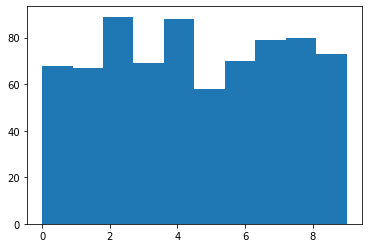

In [90]:
_, inc_ind = get_acc(unlabel_data_labels[indices], rest_label[indices])
plt.hist(rest_label[inc_ind])

In [91]:
973-88

885

(array([1216., 4254.,  957., 1022.,  973.,  856., 1970., 2851., 1960.,
        3941.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

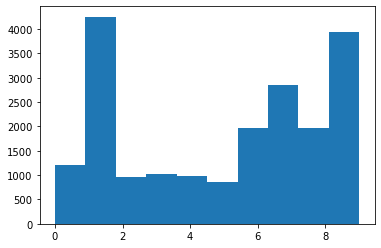

In [84]:
plt.hist(rest_label[indices])

In [71]:
acc_list = []
for l in list(range(750, 50750, 1000)):
    _, indices = torch.topk(torch.tensor(unlabel_entropy), l, largest=False)
    indices = indices.tolist()
    acc_list.append(get_acc(unlabel_data_labels[indices], rest_label[indices]))

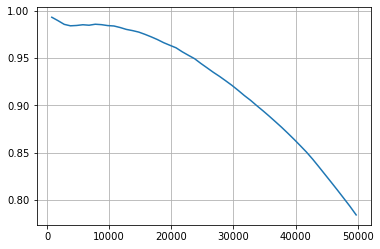

In [74]:
plt.plot(list(range(750, 50750, 1000)), acc_list)
plt.grid(True)

In [ ]:
# feature_mat, label_arr = sem_sup_feature(net, combined_dataloader)

In [ ]:
# import umap
# reducer = umap.UMAP(metric = "cosine", spread = .1)
# feature_and_weight = np.concatenate([feature_mat[unlabel_index], net.linear_class.weight.data.cpu().numpy()])
# embedding = reducer.fit_transform(feature_and_weight)

# unlabel_embedding = embedding[:len(unlabel_index)]
# label_embedding = embedding[[unlabel_index.index(i) for i in label_index]]
# weight_embedding = embedding[-10:]

In [ ]:
                                                                                                                                                                                                       # fig = plt.figure(figsize=(7,7))
# plt.scatter(unlabel_embedding[:,0], unlabel_embedding[:,1], s=1, alpha = 0.8, 
#             c = label_arr[unlabel_index], cmap="tab10")
# plt.grid(True)
# plt.tick_params(axis='x', colors=(0,0,0,0))
# plt.tick_params(axis='y', colors=(0,0,0,0))
# plt.scatter(label_embedding[:,0], label_embedding[:,1], marker='o', color='b', alpha=.4)
# plt.scatter(weight_embedding[:,0], weight_embedding[:,1], marker='o', color='r', alpha=.7)
# plt.title("UMAP -- for trainable weight")
# # plt.savefig('temp')

# canvas = FigureCanvas(fig)
# ax = fig.gca()

# # ax.text(0.0,0.0,"Test", fontsize=45)
# # ax.axis('off')

# canvas.draw()       # draw the canvas, cache the renderer
# width, height = fig.get_size_inches() * fig.get_dpi()
# width, height = int(width), int(height)
# img = np.fromstring(canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)